应用pyeda生成参考文档中真值表对应的表达式，即：
| $x$ | $f(x)$ |
 | :-----| ----: |
 | 000 | 101 | 
 | 001 | 010 | 
 | 010 | 101 | 
 | 011 | 010 | 
 | 100 | 000 | 
 | 101 | 110 | 
 | 110 | 000 | 
 | 111 | 110 | 

In [1]:
from pyeda.inter import exprvar, truthtable, truthtable2expr
# Define the input variables
a, b , c  = map(exprvar, 'abc')

# Define the truth table outputs for each function
f1_outputs = [1, 0, 1, 0, 0, 1, 0, 1]  # Output for f1
f2_outputs = [0, 1, 0, 1, 0, 1, 0, 1]  # Output for f2
f3_outputs = [1, 0, 1, 0, 0, 0, 0, 0]  # Output for f3

# Convert truth values to expressions for f1, f2, f3
f1 = truthtable([a, b, c], f1_outputs)
f2 = truthtable([a, b, c], f2_outputs)
f3 = truthtable([a, b, c], f3_outputs)

# Convert truth tables to expressions
f1_expr = truthtable2expr(f1).simplify()
f2_expr = truthtable2expr(f2).simplify()
f3_expr = truthtable2expr(f3).simplify()

# Print the derived expressions
print("f1(A, B, C) =", f1_expr)
print("f2(A, B, C) =", f2_expr)
print("f3(A, B, C) =", f3_expr)

f1(A, B, C) = Or(And(~a, ~b, ~c), And(~a, b, ~c), And(a, ~b, c), And(a, b, c))
f2(A, B, C) = Or(And(a, ~b, ~c), And(a, b, ~c), And(a, ~b, c), And(a, b, c))
f3(A, B, C) = Or(And(~a, ~b, ~c), And(~a, b, ~c))


根据逻辑表达式，生成对应的oracle

In [2]:
from qiskit.circuit.classicalfunction import classical_function
from qiskit.circuit.classicalfunction.types import Int1
 
@classical_function
def simon_oracle_f1(a: Int1, b: Int1, c: Int1) -> Int1:
    return (not a and not c) or (a and c)
@classical_function
def simon_oracle_f2(a: Int1, b: Int1, c: Int1) -> Int1:
    return a
@classical_function
def simon_oracle_f3(a: Int1, b: Int1, c: Int1) -> Int1:
    return not a and not c
 
f1 = simon_oracle_f1.synth(registerless=True)
f2 = simon_oracle_f2.synth(registerless=True)
f3 = simon_oracle_f3.synth(registerless=True)

print("f1:",f1.draw(),"\n")
print("f2:",f2.draw(),"\n")
print("f3:",f3.draw(),"\n")

f1:                
q_0: ──■───────
       │       
q_1: ──┼───────
       │       
q_2: ──┼────o──
     ┌─┴─┐┌─┴─┐
q_3: ┤ X ├┤ X ├
     └───┘└───┘ 

f2:           
q_0: ──■──
       │  
q_1: ──┼──
       │  
q_2: ──┼──
     ┌─┴─┐
q_3: ┤ X ├
     └───┘ 

f3:           
q_0: ──o──
       │  
q_1: ──┼──
       │  
q_2: ──o──
     ┌─┴─┐
q_3: ┤ X ├
     └───┘ 



根据oracle生成所需的线路，并运行

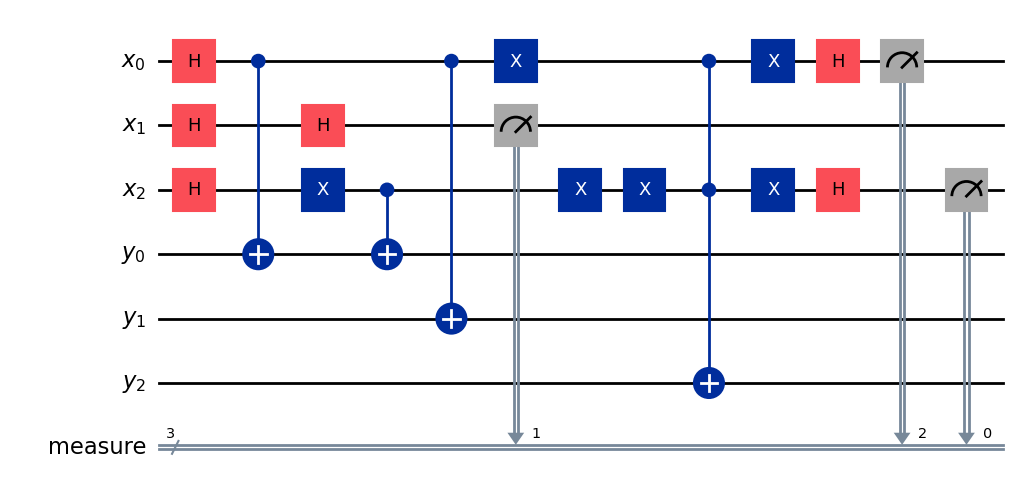

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

oracle_space = QuantumRegister(3, 'x')
f_space = QuantumRegister(3, 'y')
c_reg = ClassicalRegister(3,'measure')

simon_qc = QuantumCircuit(oracle_space,f_space,c_reg)

# h on the first resgister
simon_qc.h(oracle_space)

# work oracle
simon_qc.cx(oracle_space[0],f_space[0])
simon_qc.x(oracle_space[2])
simon_qc.cx(oracle_space[2],f_space[0])
simon_qc.x(oracle_space[2])

simon_qc.cx(oracle_space[0],f_space[1])

simon_qc.x(oracle_space[0])
simon_qc.x(oracle_space[2])
simon_qc.mcx([oracle_space[0],oracle_space[2]],f_space[2])
simon_qc.x(oracle_space[0])
simon_qc.x(oracle_space[2])

# h on the first resgister
simon_qc.h(oracle_space)

# measure
for i in range(3):
        simon_qc.measure(oracle_space[i], c_reg[2-i])

simon_qc.draw(output='mpl')

In [4]:
from qiskit.primitives import Sampler
result = Sampler().run(simon_qc).result()
result.quasi_dists

[{0: 0.25, 1: 0.25, 4: 0.25, 5: 0.25}]

经典求解

In [5]:
import numpy as np

def to_binary_vector(num, length):
    """Convert an integer to a binary vector of a given length."""
    return [int(bit) for bit in format(num, f'0{length}b')]

def gaussian_elimination_mod2(matrix):
    """Perform Gaussian elimination on the matrix modulo 2."""
    rows, cols = matrix.shape
    for i in range(rows):
        # Ensure the pivot element is 1. If not, swap with a row below that has a 1 in this column
        if matrix[i, i] == 0:
            for j in range(i + 1, rows):
                if matrix[j, i] == 1:
                    matrix[[i, j]] = matrix[[j, i]]
                    break
        # Eliminate the column below the pivot
        for j in range(i + 1, rows):
            if matrix[j, i] == 1:
                matrix[j] = (matrix[j] + matrix[i]) % 2

def find_non_trivial_solution(matrix):
    """Find a non-trivial solution to the system of equations represented by the matrix."""
    rows, cols = matrix.shape
    free_variables = []

    # Identify free variables (columns with no pivots)
    for col in range(cols - 1):
        if np.count_nonzero(matrix[:, col]) == 0:
            free_variables.append(col)

    if not free_variables:
        return np.zeros(cols - 1, dtype=int)
    
    # Set the first free variable to 1 to find a non-trivial solution
    solution = np.zeros(cols - 1, dtype=int)
    solution[free_variables[0]] = 1
    
    # Back substitution to adjust dependent variables
    for i in range(rows - 1, -1, -1):
        pivot_col = np.argmax(matrix[i, :cols - 1])
        if matrix[i, pivot_col] == 1:
            solution[pivot_col] = (matrix[i, -1] - np.dot(matrix[i, :cols - 1], solution)) % 2
    
    return solution

def simons_algorithm(measurements, bit_length):
    """
    Main function to solve Simon's problem.
    
    Parameters:
    measurements (list): List of integers representing the measurements.
    bit_length (int): Length of the bit strings.
    
    Returns:
    numpy.ndarray: The non-trivial hidden string s.
    """
    # Convert measurements to binary vectors
    binary_measurements = np.array([to_binary_vector(m, bit_length) for m in measurements])
    # Append a zero column (right-hand side of equations)
    augmented_matrix = np.hstack([binary_measurements, np.zeros((len(measurements), 1), dtype=int)])

    # Perform Gaussian elimination
    gaussian_elimination_mod2(augmented_matrix)
    # Find and return the non-trivial solution
    non_trivial_solution = find_non_trivial_solution(augmented_matrix)

    return non_trivial_solution

In [6]:
# Example usage
measurements = [1, 5]
bit_length = 3
hidden_string = simons_algorithm(measurements, bit_length)
print("Non-trivial hidden string s:", hidden_string)

Non-trivial hidden string s: [0 1 0]
